In [1]:
# Goal: Show estimated oxygen mass as a function of oxygen fill-fraction
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import numba
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils

In [2]:
# TODO: move those models to a common model package
MODEL_PREFIX = 'oxygen_tau_'
MODELS = {
    'full_multiline_nlte0.1': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.7': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.7,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.1_jet': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=True, multizone_blue_wing_enable=True),
    'full_multiline_nlte0.1_mz': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6560, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=False, multizone_blue_wing_enable=False),
    'full_multiline_nlte0.1_mz_jet': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=300e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=True, multizone_blue_wing_enable=True, multizone_reverse_tau_max_ratio=0.4),
    'full_multiline_nlte0.1_mz_shell': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6540, extra_lines=np.array([5500, 6190, 6230]), max_width=29, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=300e-14, multizone_lines=[6190, 6230], multizone_max_width=30, multizone_thick_shell=np.array([6190, 6230])),
    'full_multiline_nlte0.1_mz_outer_shell': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6540, extra_lines=np.array([5500, 6180, 6230]), max_width=28, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=300e-14, multizone_lines=[6190, 6240], multizone_max_width=30, multizone_thick_shell=np.array([6190])),
    'full_multiline_nlte0.01': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.01_mz': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6240]),
    #'full_multiline_nlte0.05': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.05,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.95': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
    'full_twoline_nlte0.1_mz': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6560, extra_lines=np.array([5500, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6230], multizone_max_width=23, multizone_reverse_tau_enable=False, multizone_blue_wing_enable=False),
    'full_twoline_nlte0.1_mz_shell': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6560, extra_lines=np.array([5500, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6230], multizone_max_width=30, multizone_reverse_tau_enable=False, multizone_blue_wing_enable=False, multizone_thick_shell=np.array([6230])),
    'full_snglline_nlte0.1': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=28, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14),
    'full_snglline_nlte0.7': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=28, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.7,  max_extra_line_amp=3e-14),
    'full_snglline_nlte0.95': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
    #'full_line6230_nlte0.1': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([6230]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14)

}

sds = specds.load_dataset('SN2019odp')
SPECS = {
    'not_late': (sds['ZTF19abqwtfu_20200113_NOT_v1'], {'scale_factor': np.sqrt(2)/9.395640563324519e-18,}),
    'keck_early': (sds['ZTF19abqwtfu_20200124_Keck1_v1'], {'scale_factor': np.sqrt(2)/7.002413899090286e-18,}),
    'keck_late': (sds['ZTF19abqwtfu_20200821_Keck1_v1'], {
        'max_width': 20,
        'scale_factor': np.sqrt(2)/3.031557125203086e-18, 
        'start5577': 5520, 'stop5577': 5669, 'start6300_6364': 6150,
    })
}

SAMPLER_PARAMS = {
    'nlive_points': 5000,
    'dynesty_method': 'rwalk',
    'dynesty_pfrac': 0.2
}

def make_model(model, spec_name, no_cache=False):
    cfg = MODELS[model]
    spec, overrides = SPECS[spec_name]
    spec = spec[~np.isnan(spec['flux'])]
    params = cfg._replace(**overrides)
    
    model_name = MODEL_PREFIX + model + '_' + spec_name
    if no_cache:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS, cache_options=set(['ignore-cache']))
    else:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS)

def spec_name_to_label(specn):
    if specn == 'not_late':
        return '+128d'
    elif specn == 'keck_early':
        return '+138d'
    elif specn == 'keck_late':
        return '+349d'
    else:
        return ''

In [8]:
for mod_name in MODELS.keys():
    for spec_name in SPECS.keys():
        #if spec_name != 'keck_late':
        #    continue
        if mod_name != 'full_multiline_nlte0.1_mz_shell':
            continue
        #if spec_name != 'keck_late':
        #    continue
        print(mod_name, spec_name)
        specmod = make_model(mod_name, spec_name, no_cache=True)
        specmod.run()

full_multiline_nlte0.1_mz_shell not_late


0it [00:00, ?it/s]

[5500 6190 6230] [False  True  True] [7372.34042553 6413.98026316 6371.59090909] [7447.23404255 6479.13815789 6436.31818182]


276432it [44:43, 103.03it/s, batch: 0 | bound: 407 | nc: 1 | ncall: 13097142 | eff(%):  2.111 | loglstar:   -inf < 9485.065 <    inf | logz: 9435.387 +/-  0.131 | dlogz:  0.000 >  0.010]  


	Mean: array([ 3.95407392e-01,  5.65365477e+03,  2.66473753e+01,  1.67165837e+01,
        1.35138635e+01,  8.50815006e-03, -4.88151492e-03,  1.98154669e+26,
       -2.10979540e+00,  1.18341931e-01, -2.44511383e+00,  5.52078822e-01,
        5.78483775e+00,  7.79849135e+00,  7.26390476e+00,  2.66949443e+01])
	Cov: array([[ 3.10381994e-02, -1.05314077e+02,  4.58312033e-02,
		         1.03368694e-02, -2.17675947e-03, -2.07527817e-05,
		         7.88798625e-07, -2.73539297e+20,  1.65425079e-02,
		         1.68329251e-03,  2.23015596e-04,  3.36456884e-02,
		        -2.11008292e-03,  1.66069334e-03, -7.64106466e-03,
		         1.93082701e-02],
		       [-1.05314077e+02,  4.73802188e+05,  1.33657536e+01,
		        -3.77194992e+01,  5.16361125e-01,  7.45574420e-02,
		        -3.67777409e-03,  1.75614822e+24, -2.33925630e+00,
		        -2.26579565e+00, -8.19642770e-01, -1.40843057e+02,
		         7.54156649e+00, -1.36271485e+00,  6.06445960e+00,
		        -3.21943138e+00],
		       [ 4.58312033e

0it [00:00, ?it/s]

[5500 6190 6230] [False  True  True] [7372.34042553 6413.98026316 6371.59090909] [7447.23404255 6479.13815789 6436.31818182]


309944it [1:21:05, 63.70it/s, batch: 0 | bound: 484 | nc: 1 | ncall: 15097170 | eff(%):  2.053 | loglstar:   -inf < 21932.938 <    inf | logz: 21876.558 +/-  0.140 | dlogz:  0.000 >  0.010]   


	Mean: array([ 3.39739636e-01,  6.20296731e+03,  2.82607437e+01,  1.72127761e+01,
        1.50686230e+01,  5.72013629e-03, -4.94110684e-03,  1.98158759e+26,
        7.26232471e-01,  8.44000968e-02, -2.33014980e+00,  5.14526276e-01,
        5.55624170e+00,  8.02111001e+00,  7.73114866e+00,  2.59729739e+01])
	Cov: array([[ 2.31381584e-02, -1.28372313e+02,  3.07739875e-03,
		         3.05366384e-03, -2.54838522e-03, -1.19682928e-05,
		         2.59880022e-07, -4.50308198e+20,  3.36111140e-03,
		         2.05574928e-04,  9.26847110e-05,  3.59839303e-02,
		        -3.28698809e-04,  1.34402957e-04, -1.10054440e-03,
		         2.24603705e-02],
		       [-1.28372313e+02,  8.58989619e+05,  1.68069517e+01,
		        -1.95474596e+01,  9.32239616e+00,  5.16149405e-02,
		        -1.42135846e-03,  3.93511814e+24, -7.80357181e+00,
		        -1.53957859e-01, -7.60369991e-01, -2.07759807e+02,
		         3.69584607e+00,  6.18169225e-02,  1.02858038e+00,
		        -7.23627822e+01],
		       [ 3.07739875e

0it [00:00, ?it/s]

[5500 6190 6230] [False  True  True] [7372.34042553 6413.98026316 6371.59090909] [7447.23404255 6479.13815789 6436.31818182]


254397it [52:54, 80.13it/s, batch: 0 | bound: 381 | nc: 1 | ncall: 12011189 | eff(%):  2.118 | loglstar:   -inf < 18032.404 <    inf | logz: 17987.134 +/-  0.126 | dlogz:  0.000 >  0.010]   


	Mean: array([ 2.96999156e+00,  2.96196624e+03,  1.85223786e+01,  1.70746389e+00,
        2.20897840e+00,  3.13540509e-03,  4.55993698e-03,  1.98157954e+26,
       -4.86762687e+00,  7.55795474e-02, -3.07217270e+00,  3.74167621e-01,
       -5.18667711e+00, -4.88214217e+00,  6.30985944e+00,  1.69793771e+01])
	Cov: array([[ 2.32648184e+00, -3.70766397e+02,  3.76851114e-02,
		         1.58389682e-02, -1.06446816e-03,  2.33285008e-04,
		        -2.12696292e-05, -4.20859937e+21, -4.01908142e-03,
		         7.92484049e-04, -7.46150858e-03,  2.46529494e-02,
		        -7.18594275e-02, -4.46759095e-01, -1.02159580e-03,
		         8.05706918e-02],
		       [-3.70766397e+02,  7.03040108e+04, -6.32471508e+00,
		        -3.46751890e+00,  2.54971319e-01, -4.61291375e-02,
		         2.02267918e-03,  9.50826252e+23,  1.38407142e+00,
		        -2.29687713e-02,  7.77631899e-01, -7.08274333e+00,
		        -4.12672693e+01,  6.58520643e+01, -1.20956203e-01,
		        -1.16657345e+01],
		       [ 3.76851114e

In [14]:
def extract_trace(specmod, idx, tidx=None):
    specmod.run()
    trace = specmod.samples
    if tidx is None:
        return trace[:,idx]
    else:
        return trace[tidx,idx]

extract_model_moi = functools.partial(extract_trace, idx=0)
extract_model_temp = functools.partial(extract_trace, idx=1)
extract_model_line_width = functools.partial(extract_trace, idx=2)
extract_model_optical_depth6300 = functools.partial(extract_trace, idx=9)
extract_model_nlte = functools.partial(extract_trace, idx=11)


def extract_model_line_velocity(specmod, tidx):
    width = extract_model_line_width(specmod, tidx=tidx)
    velocity_sigma = width/6300 * 299792.458
    return 2*np.sqrt(np.log(2)) * velocity_sigma

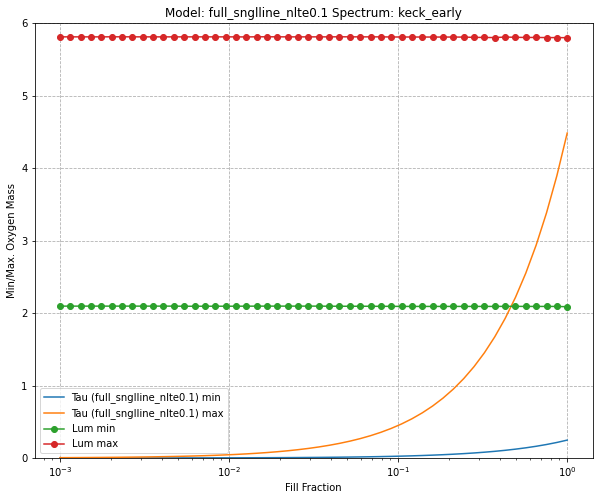

In [11]:
@numba.njit(inline='always')
def nu1_calc_lte(temp):
    g_u1 = 5
    g_g = 9
    E_1 = 22830 # K
    return g_u1/g_g * np.exp(-E_1/temp)

# simple estimate just solving eqn48 in J+Handbook to N_u
@numba.njit(inline='always')
def nu2_estimate0(temp, ne):
    Q_2g = 8.631e-6/temp**0.5 * 1 / 1 * ne
    Q_21 = 8.631e-6/temp**0.5 * 0.07 / 1 * ne
    E_u2 = 48620 # K
    E_u1 = 22830 # K
    A_21 = 1.26
    N_1 = nu1_calc_lte(temp)
    el1 = Q_2g*np.exp(-E_u2/temp)*1/9 + N_1*Q_21*np.exp(-(E_u2-E_u1)/temp)*1/5
    el2 = A_21 + Q_21 + Q_2g
    return el1/el2

@numba.njit(inline='always')
def nu2_calc_lte(temp):
    g_u2 = 1
    g_g = 9
    E_2 = 48620 # K
    return g_u2/g_g * np.exp(-E_2/temp)

def plot(model_name, spec_name, max_temp=1e5):
    label = model_name
    specmod = make_model(model_name, spec_name)
    specmod.run()
    spec_time = specmod.spec.meta['obs_mjd'] - 58714.5
    spec_time *= 3600*24
    
    if max_temp is not None:
        tidx = specmod.samples[:,1] < max_temp
    else:
        tidx = None
    
    f_o = np.logspace(-3, 0)

    line_velocity = extract_model_line_velocity(specmod, tidx=tidx)
    tau6300 = extract_model_optical_depth6300(specmod, tidx=tidx)
    #model_moi = extract_model_moi(specmod)
    inferred_moi = tau6300/oxygen.optical_depth_from_line_volume(6300, 1.0, line_velocity, spec_time,fill_factor=1.0)
    
    moi_tau = np.empty_like(f_o)
    moi_tau_std = np.empty_like(f_o)
    moi_tau_q1 = np.empty_like(f_o)
    moi_tau_q95 = np.empty_like(f_o)
    for i in range(len(f_o)):
        m = inferred_moi*f_o[i]
        mean, std = np.nanmean(m), np.nanstd(m)
        moi_tau[i] = mean
        moi_tau_std[i] = std
        moi_tau_q1[i] = np.percentile(m, 1)
        moi_tau_q95[i] = np.percentile(m, 95)
    #plt.errorbar(f_o, moi_tau, yerr=moi_tau_std, label='Tau (%s)' % label)
    plt.plot(f_o, moi_tau_q1, label='Tau (%s) min' % label)
    plt.plot(f_o, moi_tau_q95, label='Tau (%s) max' % label)
    
    # now extract the matching slice from the model trace
    temp = np.linspace(3000, 7500)
    nefo = np.array([2.181e8, 2.88e8, 3.48e8])
    nefo_temp = np.array([2500, 5000, 7500])
    nefo_interp = np.interp(temp, nefo_temp, nefo)
    temp_stepsize = np.min(np.diff(temp))
    
    trace = specmod.samples[tidx]
    
    moi_lum = np.empty_like(f_o)
    moi_lum_std = np.empty_like(f_o)
    moi_lum_q1 = np.empty_like(f_o)
    moi_lum_q99 = np.empty_like(f_o)
    for i in range(len(f_o)):
        idx = np.zeros_like(trace.shape[0], dtype=np.bool)
        for j in range(len(temp)):
            n_e = nefo_interp[j]/np.sqrt(f_o[i])
            d2 = nu2_estimate0(temp[j], n_e)/nu2_calc_lte(temp[j])
            idx2 = np.logical_and(np.abs(trace[:,1]-temp[j]) < 100, np.abs(trace[:,11]-d2) < 0.2)
            #idx2 = np.logical_and(np.abs(trace[:,1]-temp[j]) < 250, trace[:,11] <= d2)
            idx = np.logical_or(idx, idx2)
        if np.count_nonzero(idx) < 3:
            moi_lum[i] = np.nan
            moi_lum_std[i] = np.nan
            moi_lum_q1[i] = np.nan
            moi_lum_q99[i] = np.nan
        else:
            x = trace[:,0][idx]
            m, s = np.nanmean(x), np.nanstd(x)
            moi_lum[i] = m
            moi_lum_std[i] = s
            moi_lum_q1[i] = np.percentile(x, 1)
            moi_lum_q99[i] = np.percentile(x, 99)
    #plt.errorbar(f_o, moi_lum, yerr=moi_lum_std, label='Lum (%s)' % label)
    plt.plot(f_o, moi_lum_q1, label='Lum min', marker='o')
    plt.plot(f_o, moi_lum_q99, label='Lum max', marker='o')
        
            
modname = 'full_snglline_nlte0.1'
plt.figure(figsize=(10, 8))
#plot('full_multiline_nlte0.1', 'keck_early')
#plot('full_snglline_nlte0.01', 'keck_early')
#plot('full_multiline_nlte0.1_mz', 'keck_early', max_temp=1e5)
plot(modname, 'keck_early', max_temp=1e6)
#plot('full_snglline_nlte0.01', 'keck_early')
plt.legend()
plt.xscale('log')
plt.xlabel('Fill Fraction')
plt.ylim((0, 6))
plt.grid(ls='--')
plt.ylabel('Min/Max. Oxygen Mass');
plt.title(f"Model: {modname} Spectrum: keck_early")
plt.savefig(f"2022-07-18-fill-factor-mass-constraint-early-{modname}.png")

In [ ]:
@numba.njit(inline='always')
def nu1_calc_lte(temp):
    g_u1 = 5
    g_g = 9
    E_1 = 22830 # K
    return g_u1/g_g * np.exp(-E_1/temp)

# simple estimate just solving eqn48 in J+Handbook to N_u
@numba.njit(inline='always')
def nu2_estimate0(temp, ne):
    Q_2g = 8.631e-6/temp**0.5 * 1 / 1 * ne
    Q_21 = 8.631e-6/temp**0.5 * 0.07 / 1 * ne
    E_u2 = 48620 # K
    E_u1 = 22830 # K
    A_21 = 1.26
    N_1 = nu1_calc_lte(temp)
    el1 = Q_2g*np.exp(-E_u2/temp)*1/9 + N_1*Q_21*np.exp(-(E_u2-E_u1)/temp)*1/5
    el2 = A_21 + Q_21 + Q_2g
    return el1/el2

@numba.njit(inline='always')
def nu2_calc_lte(temp):
    g_u2 = 1
    g_g = 9
    E_2 = 48620 # K
    return g_u2/g_g * np.exp(-E_2/temp)

KM_TO_CM = u.km.to(u.cm)
MSOL_TO_G = u.Msun.to(u.g)

def plot_late(model_name, spec_name, max_temp=1e5):
    label = model_name
    specmod = make_model(model_name, spec_name)
    specmod.run()
    spec_time = specmod.spec.meta['obs_mjd'] - 58714.5
    spec_time *= 3600*24
    
    if max_temp is not None:
        tidx = specmod.samples[:,1] < max_temp
    else:
        tidx = np.ones(specmod.sample.shape[0], dtype=np.bool)
        
    trace = specmod.samples[tidx]
    print(trace.shape)
    
    f_o = np.logspace(-3, 0)

    line_velocity = extract_model_line_velocity(specmod, tidx=tidx)
    tau6300 = extract_model_optical_depth6300(specmod, tidx=tidx)
    #model_moi = extract_model_moi(specmod)
    inferred_moi = tau6300/oxygen.optical_depth_from_line_volume(6300, 1.0, line_velocity, spec_time,fill_factor=1.0)
    
    mp = aconst.m_p.cgs.value
    
    moi_tau = np.empty_like(f_o)
    moi_tau_std = np.empty_like(f_o)
    moi_tau_q1 = np.empty_like(f_o)
    moi_tau_q95 = np.empty_like(f_o)
    n_e = np.empty_like(f_o)
    n_e_std = np.empty_like(f_o)
    
    for i in range(len(f_o)):
        m = inferred_moi*f_o[i]
        mean, std = np.nanmean(m), np.nanstd(m)
        moi_tau[i] = mean
        moi_tau_std[i] = std
        moi_tau_q1[i] = np.percentile(m, 1)
        moi_tau_q95[i] = np.percentile(m, 95)
        
        xe = 0.1
        ne = xe * trace[:,0] * MSOL_TO_G / 16 / mp / (4*np.pi/3 * (line_velocity*KM_TO_CM*spec_time)**3 * f_o[i])
        
        n_e[i] = np.nanmean(ne)
        n_e_std[i] = np.nanstd(ne)
    #plt.errorbar(f_o, moi_tau, yerr=moi_tau_std, label='Tau (%s)' % label)
    plt.plot(f_o, moi_tau_q1, label='Tau (%s) min' % label)
    plt.plot(f_o, moi_tau_q95, label='Tau (%s) max' % label)
    
    print(n_e)
    
    temp = np.linspace(3000, 9000)
    
    trace = specmod.samples[tidx]
    
    moi_lum = np.empty_like(f_o)
    moi_lum_std = np.empty_like(f_o)
    moi_lum_q1 = np.empty_like(f_o)
    moi_lum_q99 = np.empty_like(f_o)
    for i in range(len(f_o)):
        idx = np.zeros_like(trace.shape[0], dtype=np.bool)
        for j in range(len(temp)):
            # estimate d2 distribution
            xe = np.random.uniform(0.01, 0.1, size=trace.shape[0])
            ne = xe * trace[:,0] * MSOL_TO_G / 16 / mp / (4*np.pi/3 * (line_velocity*KM_TO_CM*spec_time)**3 * f_o[i])
            d2 = nu2_estimate0(temp[j], ne)/nu2_calc_lte(temp[j])
            #ne = n_e[i]
            #d2 = nu2_estimate0(temp[j], ne)/nu2_calc_lte(temp[j])
            #idx_d2 = np.logical_and(trace[:,11] > d2.min())
            idx2 = np.logical_and(np.abs(trace[:,1]-temp[j]) < 100, np.abs(trace[:,11]-d2) < 0.1)
            #idx2 = np.logical_and(np.abs(trace[:,1]-temp[j]) < 250, trace[:,11] <= d2)
            idx = np.logical_or(idx, idx2)
        if np.count_nonzero(idx) < 3:
            moi_lum[i] = np.nan
            moi_lum_std[i] = np.nan
            moi_lum_q1[i] = np.nan
            moi_lum_q99[i] = np.nan
        else:
            x = trace[:,0][idx]
            m, s = np.nanmean(x), np.nanstd(x)
            moi_lum[i] = m
            moi_lum_std[i] = s
            moi_lum_q1[i] = np.percentile(x, 1)
            moi_lum_q99[i] = np.percentile(x, 99)
    #plt.errorbar(f_o, moi_lum, yerr=moi_lum_std, label='Lum (%s)' % label)
    plt.plot(f_o, moi_lum_q1, label='Lum min', marker='o')
    plt.plot(f_o, moi_lum_q99, label='Lum max', marker='o')
        
            
modname = 'full_multiline_nlte0.1_mz_shell'
plt.figure(figsize=(10, 8))
#plot('full_multiline_nlte0.1', 'keck_early')
#plot('full_snglline_nlte0.01', 'keck_early')
#plot('full_multiline_nlte0.1_mz', 'keck_early', max_temp=1e5)
plot_late(modname, 'keck_late', max_temp=1e6)
#plot('full_snglline_nlte0.01', 'keck_early')
plt.legend()
plt.xscale('log')
plt.xlabel('Fill Fraction')
#plt.ylim((0, 6))
plt.grid(ls='--')
plt.ylabel('Min/Max. Oxygen Mass');
plt.title(f"Model: {modname} Spectrum: keck_late")
plt.savefig(f"2022-07-18-fill-factor-mass-constraint-late-{modname}.png")

In [ ]:
specmod = make_model('full_multiline_nlte0.95', 'keck_late')
trace = specmod.samples
plt.hist(trace[:,11])

192121


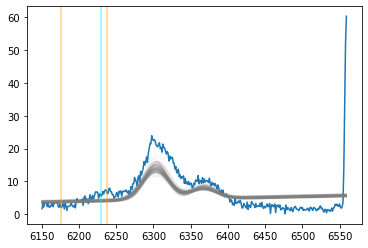

In [51]:
# render the very NLTE models
s_name = 'keck_late'
m_name = 'full_twoline_nlte0.1_mz_shell'
specmod = make_model(m_name, s_name)
specmod.run()
cfg = specmod.params

spec = SPECS[s_name][0]
idx = np.logical_and(spec['restwave'] > cfg.start6300_6364, spec['restwave'] < cfg.stop6300_6364)
wave = spec['restwave'][idx]
plt.plot(wave, spec[idx]['flux']*cfg.scale_factor)

# now select large nlte deviation
trace = specmod.samples
idx = trace[:,11] < 1.0
print(np.count_nonzero(idx))
trace_s = trace[idx]
for i in np.random.randint(0, np.count_nonzero(idx)-1, size=100):
    p = trace_s[i]
    #print(p.shape)
    f = oxygen.render(cfg=specmod.params, p=p, wave=wave)
    plt.plot(wave, f, alpha=0.1, lw=1, color='grey')
for line in cfg.extra_lines:
    if line > 6100:
        plt.axvline(line, color='cyan', alpha=0.5)
#plt.axvline(6300-64, color='orange')
#plt.axvline(6300+64, color='orange')
#plt.axvline(6240)
#plt.axvline(6170)
for i in [3000, 6000]:
    plt.axvline(oxygen.velocity2line(6300, i), color='orange', alpha=0.5)
plt.savefig(f"2022-07-18-oxygen-model-specfit-{s_name}-{m_name}.png")

In [ ]:
# render the very NLTE models
s_name = 'not_late'
specmod = make_model('full_multiline_nlte0.1_mz', s_name)
specmod.run()
cfg = specmod.params

spec = SPECS[s_name][0]
idx = np.logical_and(spec['restwave'] > cfg.start5577-300, spec['restwave'] < cfg.stop5577+100)
wave = spec['restwave'][idx]
plt.plot(wave, spec[idx]['flux']*cfg.scale_factor)
idx = np.logical_and(spec['restwave'] > cfg.start5577, spec['restwave'] < cfg.stop5577)
wave = spec['restwave'][idx]

# now select large nlte deviation
trace = specmod.samples
idx = trace[:,11] < 1.0
trace_s = trace[idx]
for i in np.random.randint(0, np.count_nonzero(idx)-1, size=100):
    p = trace_s[i]
    #print(p.shape)
    f = oxygen.render(cfg=specmod.params, p=p, wave=wave)
    plt.plot(wave, f, alpha=0.1, lw=1, color='grey')
for i in [3000, 6000]:
    plt.axvline(oxygen.velocity2line(5577, i))

(309944, 16)


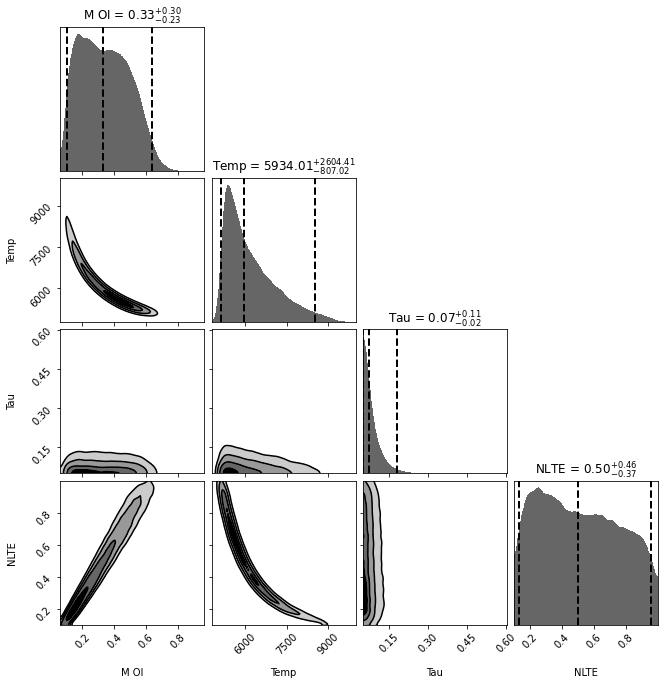

In [28]:
s_name = 'keck_early'
m_name = 'full_multiline_nlte0.1_mz_shell'
specmod = make_model(m_name, s_name)
specmod.run()
print(specmod.samples.shape)
LABELS=['M OI', 'Temp', 'Tau', 'NLTE']
dyplot.cornerplot(specmod.results, dims=[0,1, 9, 11], show_titles=True, labels=LABELS);
plt.savefig(f"2022-07-18-oxygen-model-corner-tiny-{s_name}-{m_name}.png")

In [ ]:
s_name = 'keck_early'
m_name = 'full_multiline_nlte0.1_mz_outer_shell'
specmod = make_model(m_name, s_name)
specmod.run()
print(specmod.samples.shape)
dyplot.cornerplot(specmod.results, dims=[0,1, 2, 8, 9, 11, 12, 13, 14, 15], show_titles=True);
plt.savefig(f"2022-07-18-oxygen-model-corner-{s_name}-{m_name}.png")

In [ ]:
s_name = 'keck_early'
m_name = 'full_snglline_nlte0.1'
specmod = make_model(m_name, s_name)
specmod.run()
dyplot.cornerplot(specmod.results, dims=[0,1, 9, 11], show_titles=True, labels=['M OI', 'Temp', 'Tau', 'NLTE']);
plt.savefig(f"2022-07-18-oxygen-model-corner-{s_name}-{m_name}.png")

In [ ]:
s_name = 'keck_early'
specmod = make_model('full_multiline_nlte0.1_mz', s_name)
specmod.run()
dyplot.cornerplot(specmod.results, dims=[12, 13, 14, 15], show_titles=True);

In [ ]:
s_name = 'keck_early'
specmod = make_model('full_multiline_nlte0.1', s_name)
specmod.run()
dyplot.cornerplot(specmod.results, dims=[12, 13, 14, 15], show_titles=True);

In [ ]:
specmod.params.extra_lines[1] in [6158]

In [ ]:
C_KMS = 2.997925e5

@numba.njit(inline='always')
def velocity2line(lambda0, velocity):
    return lambda0*C_KMS/(velocity+C_KMS)

@numba.njit(inline='always')
def line2velocity(wave0, wave):
    return wave0*C_KMS/wave-C_KMS

print(line2velocity(6300, 6158))
print(velocity2line(6300, -6913)-6300)

In [10]:
def plot_spec_render(ax, m_name, s_name, region):
    specmod = make_model(m_name, s_name)
    specmod.run()
    cfg = specmod.params

    spec = SPECS[s_name][0]
    if region == '63xx':
        idx = np.logical_and(spec['restwave'] > cfg.start6300_6364, spec['restwave'] < cfg.stop6300_6364)
        plt_idx = np.logical_and(spec['restwave'] > cfg.start6300_6364-100, spec['restwave'] < cfg.stop6300_6364+100)
        ax.axvline(cfg.start6300_6364, color='cyan')
        ax.axvline(cfg.stop6300_6364, color='cyan')
    elif region == '5577':
        idx = np.logical_and(spec['restwave'] > cfg.start5577, spec['restwave'] < cfg.stop5577)
        plt_idx = np.logical_and(spec['restwave'] > cfg.start5577-100, spec['restwave'] < cfg.stop5577+100)
        ax.axvline(cfg.start5577, color='cyan')
        ax.axvline(cfg.stop5577, color='cyan')
    wave = spec['restwave'][idx]
    ax.plot(spec['restwave'][plt_idx], spec[plt_idx]['flux']*cfg.scale_factor, label=s_name)

    # now select large nlte deviation
    trace = specmod.samples
    #idx = trace[:,11] > 0
    idx = trace[:,0] > 0
    print(np.count_nonzero(idx))
    trace_s = trace[idx]
    for i in np.random.randint(0, np.count_nonzero(idx)-1, size=200):
        p = trace_s[i]
        #print(p.shape)
        f = oxygen.render(cfg=specmod.params, p=p, wave=wave)
        ax.plot(wave, f, alpha=0.1, lw=0.5, color='grey')
    ax.legend()
    ax.set_xlabel('Rest Wavelength [A]')
    for line in cfg.extra_lines:
        if line > 5577 and region == '63xx':
            ax.axvline(line, color='orange', alpha=0.5)
        elif line < 5577 and region == '5577':
            ax.axvline(line, color='orange', alpha=0.5)
    
# diagnostic plot (2x2 grid: left column early; right column late; top 63xx; bottom 5577)
def plot_diag(m_name):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11,11))
    
    plot_spec_render(ax1, m_name, 'keck_early', '63xx')
    plot_spec_render(ax2, m_name, 'keck_late', '63xx')
    plot_spec_render(ax3, m_name, 'keck_early', '5577')
    plot_spec_render(ax4, m_name, 'keck_late', '5577')
    
    fig.savefig(f'2022-07-18-oxygen-fit-diag-{m_name}.png')
    
#plot_diag('full_snglline_nlte0.1')

238563
238563


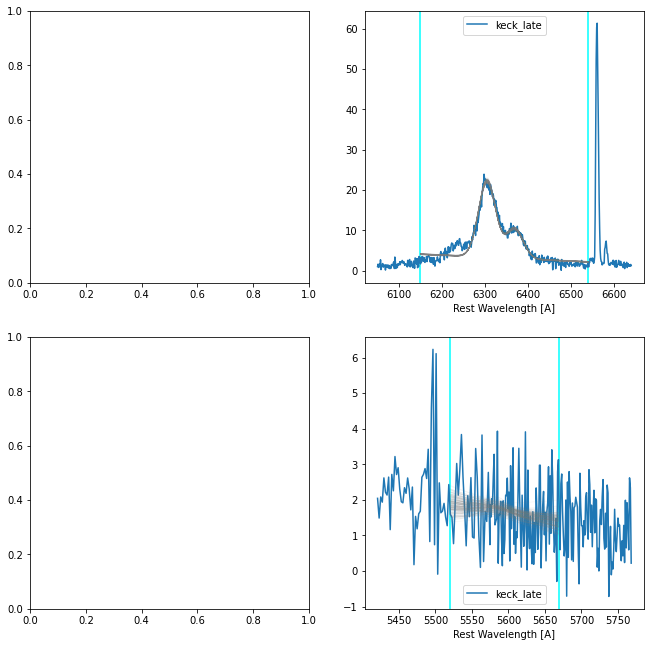

In [6]:
plot_diag('full_snglline_nlte0.1')

281694
190748
281694
190748


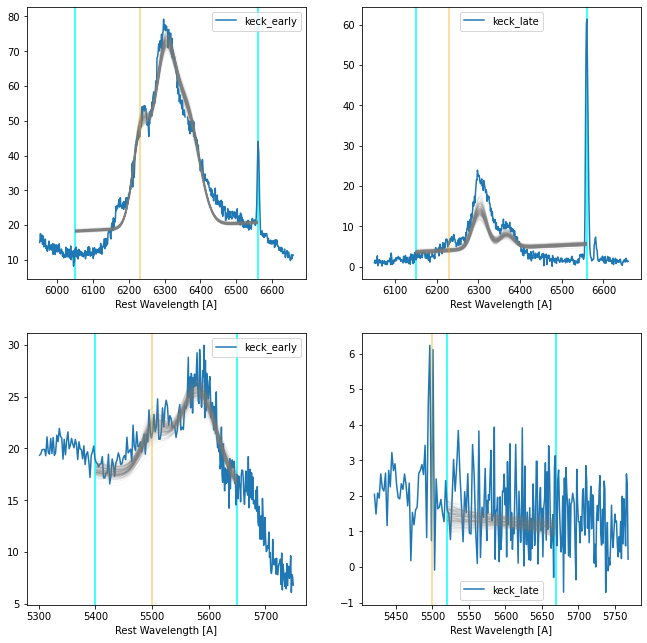

In [97]:
plot_diag('full_twoline_nlte0.1_mz')

283264
192121
283264
192121


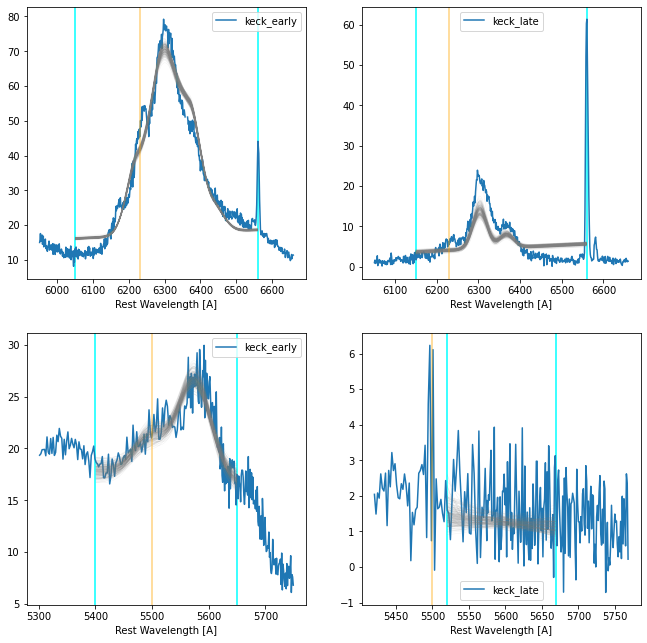

In [98]:
plot_diag('full_twoline_nlte0.1_mz_shell')

94267
41051
94267
41051


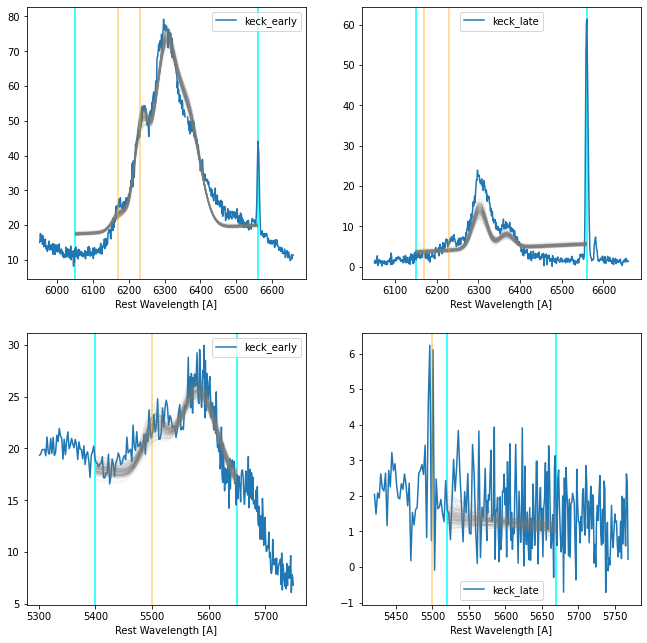

In [81]:
plot_diag('full_multiline_nlte0.1_mz')

309944
254397
309944
254397


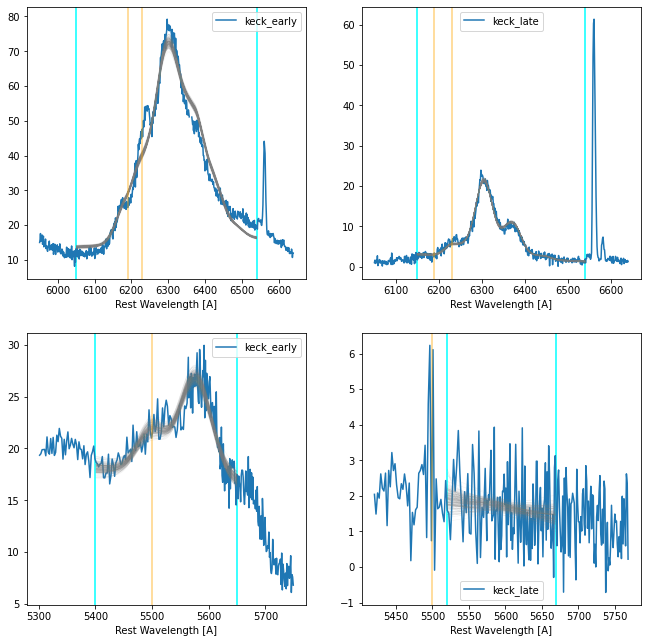

In [11]:
plot_diag('full_multiline_nlte0.1_mz_shell')

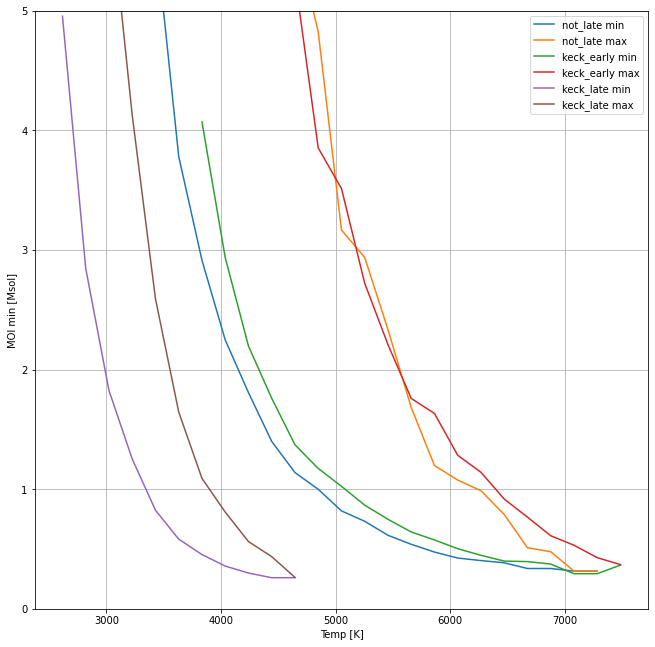

In [15]:
# diag showing minimum mass as function of temperature
def plot_min_mass_temp(m_name):
    fig, ax = plt.subplots(1, figsize=(11,11))
    
    for s_name in SPECS.keys():
        specmod = make_model(m_name, s_name)
        specmod.run()
        
        moi = extract_model_moi(specmod)
        temp = extract_model_temp(specmod)
        
        temps = np.linspace(np.exp(6.9), np.exp(6.9+2.4))
        d_temp = np.diff(temps).mean()
        moi_min = np.empty_like(temps)
        moi_max = np.empty_like(temps)
        for i in range(len(temps)):
            #idx = temp < temps[i]
            idx = np.abs(temp - temps[i]) <= d_temp
            if np.count_nonzero(idx) == 0:
                moi_min[i] = np.nan
                moi_max[i] = np.nan
                continue
            moi_min[i] = moi[idx].min()
            moi_max[i] = moi[idx].max()
        ax.plot(temps, moi_min, label=s_name + ' min')
        ax.plot(temps, moi_max, label=s_name + ' max')
    ax.legend()
    ax.grid()
    ax.set_ylim((0,5))
    ax.set_xlabel('Temp [K]')
    ax.set_ylabel('MOI min [Msol]')
    fig.savefig(f'2022-07-18-temp-minmax-mass-{m_name}.png')

        
plot_min_mass_temp('full_snglline_nlte0.1')


Got error while trying to unpickle cache file..
Traceback (most recent call last):
  File "../lib/snelib19odp/cache.py", line 91, in get_product
    return pickle.load(f)
TypeError: __new__() missing 3 required positional arguments: 'multizone_blue_wing_enable', 'multizone_reverse_tau_max_ratio', and 'multizone_thick_shell'
0it [00:00, ?it/s]

[5500 6170 6230] [False  True  True] [7372.34042553 6435.59602649 6371.59090909] [7447.23404255 6500.97350993 6436.31818182]


264281it [50:39, 86.94it/s, batch: 0 | bound: 421 | nc: 1 | ncall: 12493607 | eff(%):  2.115 | loglstar:   -inf < -425.078 <    inf | logz: -472.327 +/-  0.125 | dlogz:  0.000 >  0.010]   


	Mean: array([ 4.10167958e+00,  4.82559717e+03,  3.24480105e+01,  1.68595039e+01,
        1.69429821e+01,  8.04714520e-03, -4.86403933e-03,  1.98156051e+26,
       -4.18661264e+00,  3.16044767e+00, -2.00647017e+00,  2.16174110e-01,
        5.48812219e+00,  4.62303191e+00,  6.77756655e+00,  2.04618883e+01])
	Cov: array([[ 1.21661369e+00, -2.91141444e+02, -7.67570863e-04,
		         5.63465869e-02, -2.26891260e-02, -6.97622179e-05,
		         1.20309265e-06,  9.84459198e+20,  1.55421699e-02,
		         2.08572091e-01, -2.05467977e-04,  5.16844020e-02,
		        -1.31239670e-02,  4.41055961e-02,  6.02187269e-03,
		         2.51624122e-02],
		       [-2.91141444e+02,  9.57192728e+04,  1.80563039e+00,
		        -2.80528586e+01, -6.02291771e+00,  3.68178410e-02,
		        -5.52744483e-04, -1.69001829e+23,  8.25677041e+00,
		         5.05912578e+01, -2.29940311e-01, -2.16219247e+01,
		         6.88764002e+00, -8.01942745e+00,  2.18054289e+00,
		         1.93701441e+01],
		       [-7.67570863e

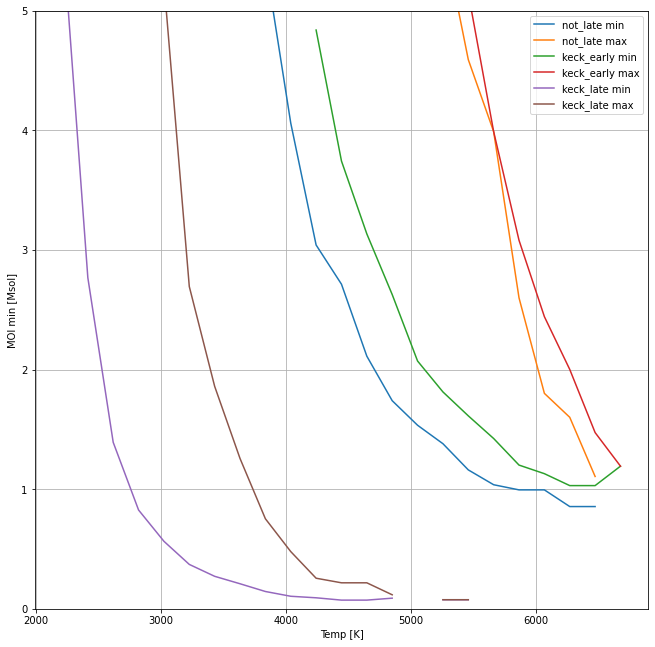

In [91]:
plot_min_mass_temp('full_multiline_nlte0.1_mz')


0it [00:00, ?it/s]

[5500 6230] [False  True] [7372.34042553 6371.59090909] [7447.23404255 6436.31818182]


250570it [49:27, 84.43it/s, batch: 0 | bound: 392 | nc: 1 | ncall: 11711777 | eff(%):  2.139 | loglstar:   -inf < -430.983 <    inf | logz: -475.489 +/-  0.122 | dlogz:  0.000 >  0.010]  


	Mean: array([ 4.01443970e+00,  4.85036245e+03,  3.23139813e+01,  1.67588998e+01,
        1.73645895e+01,  7.93400681e-03, -4.83122489e-03,  1.98155844e+26,
       -3.56889102e+00,  3.29988438e+00, -1.98171858e+00,  2.18757773e-01,
        5.55366299e+00,  6.85907221e+00,  2.20899312e+01])
	Cov: array([[ 1.32231714e+00, -3.21866427e+02, -1.61119044e-03,
		         7.69267033e-02, -2.56572167e-02, -1.30213459e-04,
		        -2.47784629e-06,  6.84453310e+20,  5.71264405e-02,
		         2.80589660e-01,  1.19744791e-04,  5.50952274e-02,
		        -1.76797842e-02,  7.02612621e-03,  8.64351198e-03],
		       [-3.21866427e+02,  1.08628917e+05,  3.31443001e+00,
		        -3.57322622e+01, -4.84238327e+00,  5.27457221e-02,
		         3.95768032e-04,  2.54955234e+22,  2.14489053e+01,
		         4.75407776e+01, -2.91247293e-01, -2.39492947e+01,
		         8.19601925e+00,  1.28974828e+00,  8.93481621e+00],
		       [-1.61119044e-03,  3.31443001e+00,  3.57501320e-01,
		         5.14897874e-04, -1.94

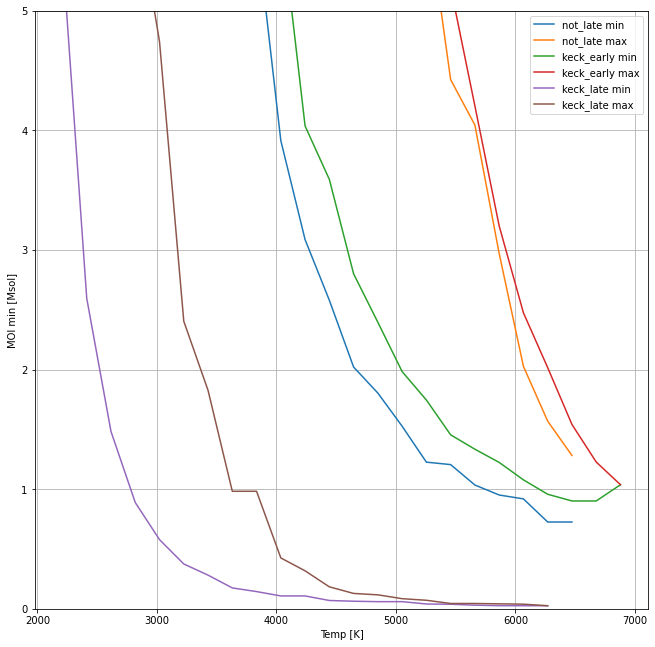

In [92]:
plot_min_mass_temp('full_twoline_nlte0.1_mz')

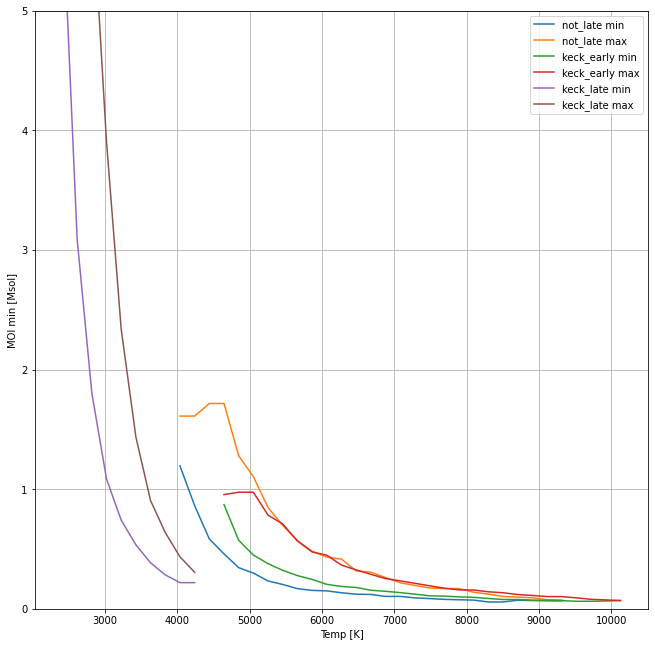

In [16]:
plot_min_mass_temp('full_multiline_nlte0.1_mz_shell')

(190748, 15)


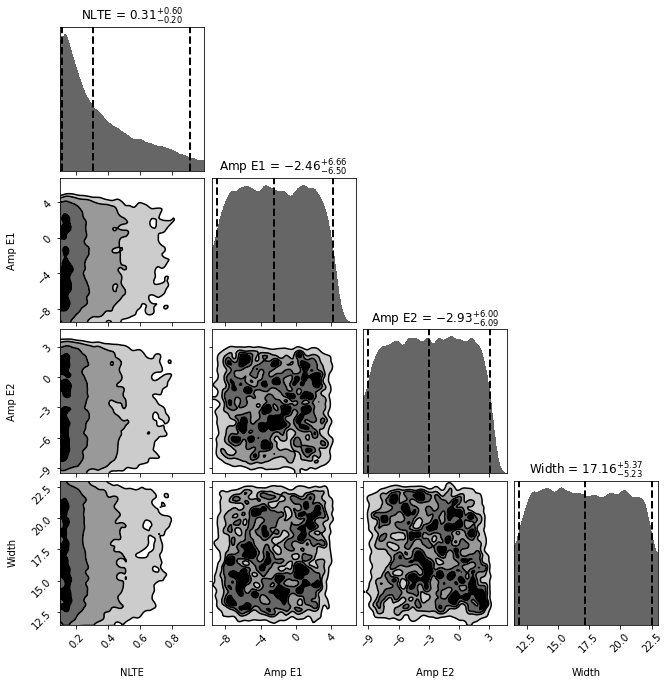

In [84]:
# temp investigation
s_name = 'keck_late'
m_name = 'full_twoline_nlte0.1_mz'
specmod = make_model(m_name, s_name)
specmod.run()
print(specmod.samples.shape)
LABELS=['NLTE', 'Amp E1', 'Amp E2', 'Width']
dyplot.cornerplot(specmod.results, dims=[11, 12, 13, 14], show_titles=True, labels=LABELS);

(238563, 12)


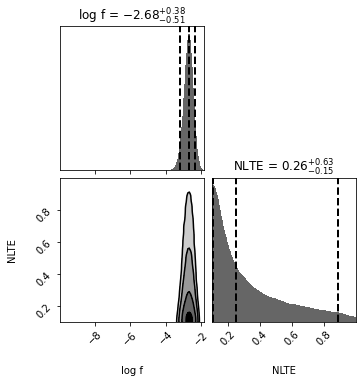

In [7]:
# temp investigation
s_name = 'keck_late'
m_name = 'full_snglline_nlte0.1'
specmod = make_model(m_name, s_name)
specmod.run()
print(specmod.samples.shape)
LABELS=['log f', 'NLTE']
dyplot.cornerplot(specmod.results, dims=[10, 11], show_titles=True, labels=LABELS);

In [21]:
# diag showing minimum mass as function of d2
def plot_min_mass_d2(m_name):
    fig, ax = plt.subplots(1, figsize=(11,11))
    
    d2 = np.logspace(-1, 0)
    
    for s_name in SPECS.keys():
        specmod = make_model(m_name, s_name)
        specmod.run()
        
        moi = extract_model_moi(specmod)
        #temp = extract_model_temp(specmod)
        m_d2 = extract_model_nlte(specmod)
        
        d_d2 = np.diff(d2)
        moi_min = np.empty_like(d2)
        moi_max = np.empty_like(d2)
        for i in range(1, len(d2)):
            idx = np.abs(m_d2 - d2[i]) <= d_d2[i-1]
            if np.count_nonzero(idx) == 0:
                moi_min[i] = np.nan
                moi_max[i] = np.nan
                continue
            moi_min[i] = moi[idx].min()
            moi_max[i] = moi[idx].max()
        ax.plot(d2, moi_min, label=s_name + ' min')
        ax.plot(d2, moi_max, label=s_name + ' max')
    ax.legend()
    ax.grid()
    ax.set_ylim((0,5))
    ax.set_xlabel('NLTE Deviation')
    ax.set_ylabel('MOI min [Msol]')
    ax.set_xscale('log')
    fig.savefig(f'2022-07-18-nlte-minmax-mass-{m_name}.png')

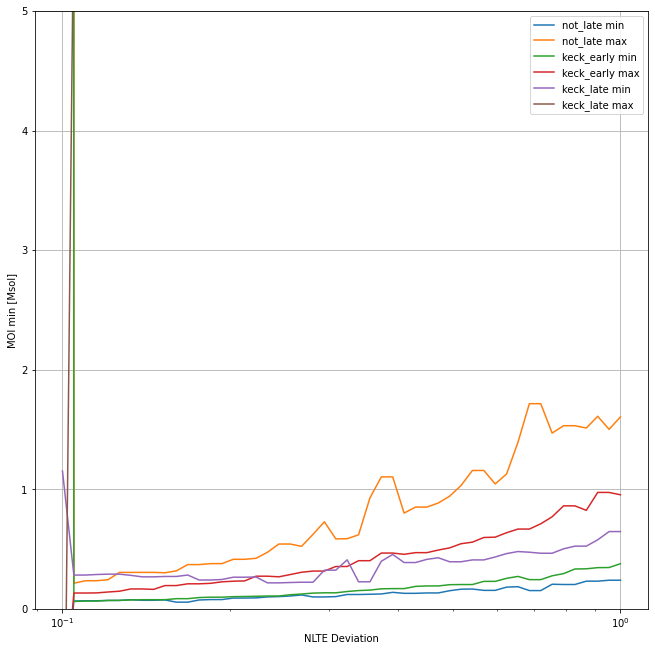

In [22]:
plot_min_mass_d2('full_multiline_nlte0.1_mz_shell')

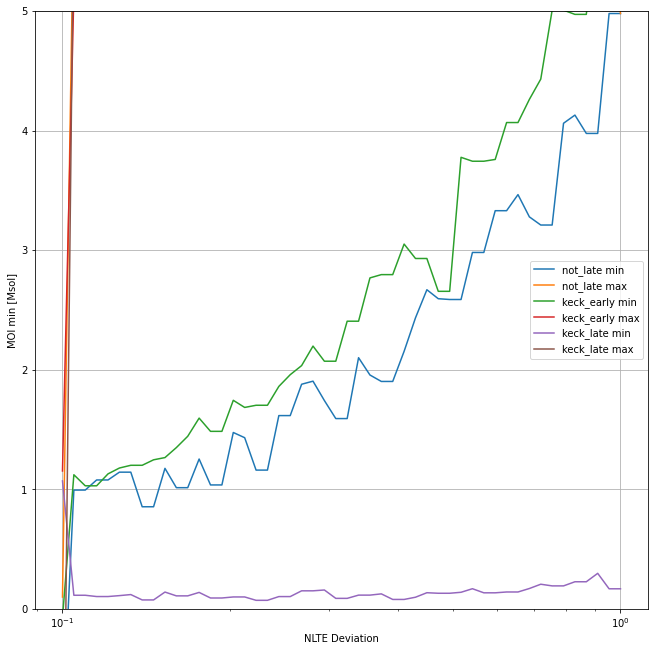

In [23]:
plot_min_mass_d2('full_multiline_nlte0.1_mz')

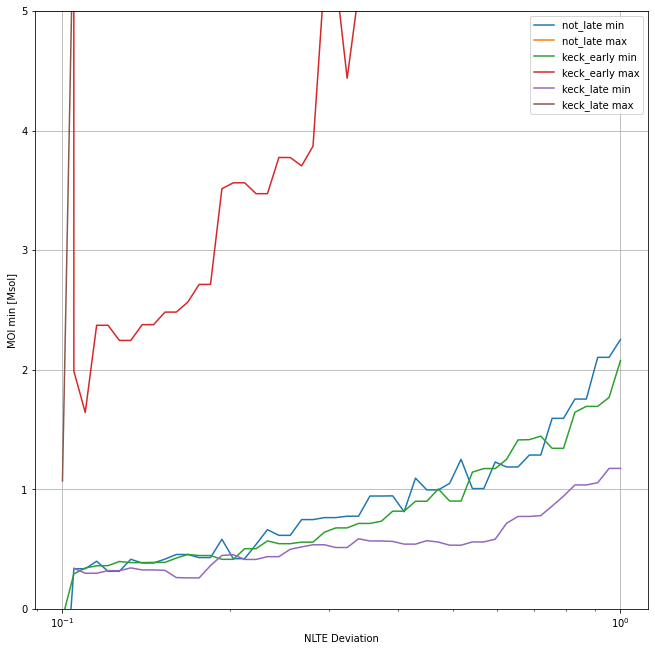

In [25]:
plot_min_mass_d2('full_snglline_nlte0.1')

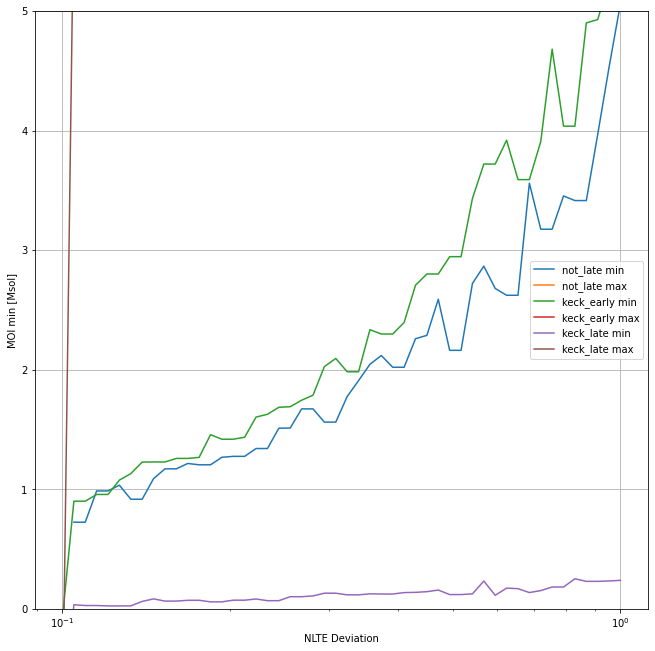

In [26]:
plot_min_mass_d2('full_twoline_nlte0.1_mz')